In [ ]:
#d(ady/dx)dx+bdy/dx+cy=f(x) s
#Used Hard PINN concept but it did not work for convection domainted Problems


In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
def a_x(x):
    return 10**(-4)
def b_x(x):
    return 1
def c_x(x):
    return 1
def f_x(x):
    return 1

In [17]:
class Model(nn.Module):
    def __init__(self,input,output,h1):
        super().__init__()
        self.fc1=nn.Linear(input,h1)
        self.fc2=nn.Linear(h1,h1)
        self.fc4=nn.Linear(h1,h1)
        self.fc3=nn.Linear(h1,output)
    def forward(self,x):
        x=torch.tanh(self.fc1(x))
        x=torch.tanh(self.fc2(x))
        x=torch.tanh(self.fc4(x))
        x=self.fc3(x)
        return x

In [18]:
x = torch.linspace(0,1,100).reshape(-1,1).requires_grad_(True)
fx=f_x(x)
ax=a_x(x)
bx=b_x(x)
cx=c_x(x)

In [19]:
torch.manual_seed(14)
model=Model(1,1,40)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [20]:
epochs=30000
loss_history=[]
for i in range(epochs):
    optimizer.zero_grad()
    ypred3=model(x)
    dy_dx = torch.autograd.grad(ypred3, x, torch.ones_like(ypred3), create_graph=True)[0]
    a_dy_dx=ax*dy_dx
    a_d2y_dx2 = torch.autograd.grad(a_dy_dx, x, torch.ones_like(a_dy_dx), create_graph=True)[0]
    F=(-a_d2y_dx2+bx*dy_dx+cx*ypred3-fx)*x*(1-x)
    loss3=1*torch.mean((F-0)**2)
    loss=loss3
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().numpy())

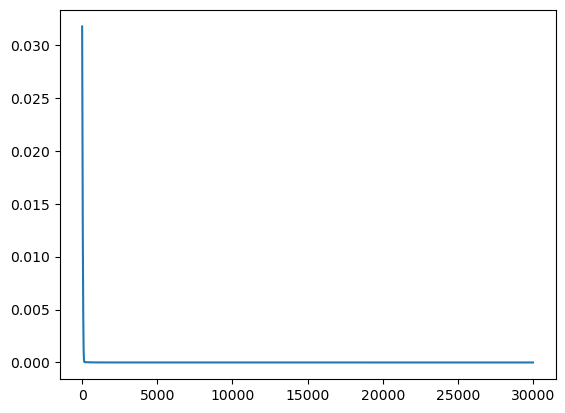

In [21]:
plt.plot(range(epochs),loss_history)

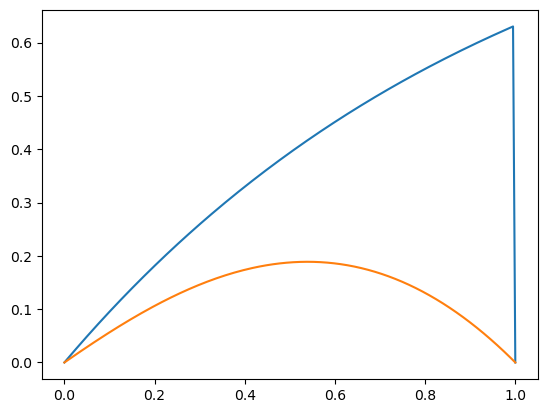

In [24]:
with torch.no_grad():
    epsilon = 10**(-4)
    e_inv = np.exp(-1)
    e_neg10001 = np.exp(-(1/epsilon+1))
    e_neg10002 = np.exp(-(1/epsilon+2))
    A = (e_inv - 1) * e_neg10001 / (1 - e_neg10002)
    B = -1 - A
    def y_stable(x):
        return ((e_inv - 1) * np.exp(-(1/epsilon+1) * (1 - x)) / (1 - e_neg10002)+ (-1 - (e_inv - 1) * e_neg10001 / (1 - e_neg10002)) * np.exp(-x) + 1)
    x= np.linspace(0,1,200).reshape(-1, 1)  

    plt.plot(x,y_stable(x))
    x=torch.FloatTensor(x)
    ypred=model.forward(x)
    y_x=ypred*x*(1-x)
    plt.plot(x,y_x)